<a id="top" style="float:right;" href="http://dynfluid.ensam.eu/"><img style="height:120px;" src="http://dynfluid.ensam.eu/uas/DYNFLUID/logoPrincipal/Logo-DynFluid-Web.png"/></a>
<a style="float:left;" href="http://www.cnam.fr//"><img style="height:120px;" src="https://upload.wikimedia.org/wikipedia/commons/4/45/Logo_ENSTA_Paris.jpg"></a>

<center>
<h3 style="color:#888888;"> <i>--  Introduction à  la méthode de Boltzmann sur Réseau  --</i> </h3>
<h1> TP n°1 </h1>
<h3> Etude d'un pulse de Pression </h3>
<h6><a href="mailto:simon.marie@lecnam.net">simon.marie@lecnam.net</a></h6>
</center>

<h1> 1 - Préambule </h1>

Le TP doit être réalisé en binôme ou individuellement et doit être rendu sous la forme d'un Notebook jupyter en respectant la nomenclature suivante:
<center>
<b>TP1_NOM1_NOM2.ipynb</b>
</center>

Tous les résultats, discussions, analyses, doivent donc être inclus dans le fichier.

In [5]:
#Import des modules utiles
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
import math
from math import floor


import time

#Option pour afficher les figures dans le notebook :
%matplotlib inline
# Ou pour avoir des résultats en temps réel dans le notebook:
#%matplotlib notebook

# Option d'affichage
fs=20
plt.rc('xtick',labelsize=fs)
plt.rc('ytick',labelsize=fs)

<h1> 2 - Présentation du TP</h1>

On se propose dans se TP d'étudier l'évolution d'un pulse de Pression à  l'aide d'un schéma LBM $D2Q4$.

<h2>Le modèle D2Q4</h2>

Le modele à 4 vitesses de la méthode de Boltzmann sur réseau est un modele lineaire permettant de resoudre
les équations de propagation d'ondes - type d'Alembert ou Helmholtz - et son algorithme s'exprime de façon
très simple.
Les paramètres du modèle sont résumées dans le tableau suivant:

<table style="width:850px;font-size:20px;text-align:center;">
    <tr><td>$\widehat{c_\alpha}$</td><td>$\omega_\alpha$</td><td>$\widehat{c_0}$</td><td>$\tau_g$</td></tr>
<tr><td>(1,0) (0,1)    (-1 0) (0 -1)</td><td>$\dfrac{1}{4},\dfrac{1}{4},\dfrac{1}{4},\dfrac{1}{4}$</td><td>$\dfrac{1}{\sqrt{2}}$</td><td>$\dfrac{1}{2}$</td></tr>
</table>


La fonction d'équilibre du modèle s'écrit:

$$
\displaystyle{g_{\alpha}^{eq}=\rho\omega_\alpha\left(1 +\dfrac{\mathbf{u}.\mathbf{c}_{\alpha}}{c_0^2}\right)}
$$

et son algorithme général:

$$
\displaystyle{g_{\alpha}^{coll} = g_{\alpha}-\dfrac{1}{\tau_g}[g_{\alpha}-g_{\alpha}^{eq}]\\
g_{\alpha}(x,y) = g_{\alpha}^{coll}(x-c_{\alpha,x},y-c_{\alpha,y})}
$$

Les variables macroscopiques sont calculées à  partir des moments des fonctions de distribution:
$$
\rho=\sum_{\alpha=1}^4 g_{\alpha}
$$

$$
\rho u_x=\sum_{\alpha=1}^4 c_{\alpha,x}g_{\alpha}
$$

$$
\rho u_y=\sum_{\alpha=1}^4 c_{\alpha,y}g_{\alpha}
$$


<b style="color:#0055FA">1. Rappeller pourquoi le modele D2Q4 ne permet pas une simulation de type Navier-Stokes</b>

**Commentaires**


___

On ne peux pas calculer jusqu'à Navier-Stokes car pour cela, il faudrait calculer les moments de la fonction de distribution jusqu'à l'ordre 2, ce qui n'est pas possible avec un réseau D2Q4. En effet, dans le modèle D2Q4, l'ordre de la quadrature vaut 1, il n'y avait pas besoin de d'avantage car les quantités d'intérêts sont linéaires en les $g_\alpha$. Les termes quadratiques qui apparaissent lorsque l'on va à l'ordre supérieur pour la simulation des équations de Navier-Stokes ne peuvent être calculés exactement uniquement si on augmente l'ordre de la quadrature, ce qui implique nécessairement d'augmenter le degré des polynômes. Cela revient à changer le modèle de la méthode.

<h2>Le Pulse de pression</h2>

Le pulse de pression est un cas test très utilisé en simulation numérique car la solution analytique est connue en 2D ou en 3D. Ainsi il devient très utile lorsque l'on souhaite évaluer quantitativement les capacités d'un schéma numérique.

<h3> Initialisation </h3>

Ce cas test consiste à  initialiser le champ de densité avec une gaussienne centrée autour d'un point $(x_0,y_0)$ et le champ de vitesse à  0:

$$
\rho(x,y,t_0)=1.+\varepsilon\exp\left(-\alpha\eta^2 \right)
$$

et

$$
\mathbf{u}(x,y,t_0)=0
$$

Avec $\eta = \sqrt{(x-x_0)^2 +(y-y_0)^2}$, $\alpha=\dfrac{ln(2)}{b^2}$ où $b$ est la demie-largeur de la gaussienne.

<h3> Solution analytique </h3>

La solution analytique de ce cas test est donnée en fonction du temps par:

$$
\displaystyle{\rho (x,y,t) = 1.+\dfrac{\varepsilon}{2\alpha}\int_0^{\infty} \xi exp\left[-\dfrac{\xi^2}{4\alpha}\right] cos(t\xi)J_0(\xi \eta) d\xi}
$$

 et

$$
\displaystyle{u_x(x,y,t) = \dfrac{(x-x_0)\varepsilon}{2\alpha\eta}\int_0^{\infty} \xi exp\left[-\dfrac{\xi^2}{4\alpha}\right] sin(t\xi)J_1(\xi \eta) d\xi}
$$

avec les fonction de Bessel sphérique de type $1$,  $J_0$ d'ordre $0$ et $J_1$ d'ordre 1.



<h1> 3 - Travail demandé</h1>

<h2>Définition des paramètres et des fonctions</h2>

        
Pour les paramètres du calcul, on prendra un domaine unitaire $(L_x, L_y)=(1,1)$ de résolution $(n_x,n_y)=(400,400)$ mailles avec $\tau_g=0.5$, $b=12$ et les paramètres du modèle D2Q4 décrits plus haut.

<b style="color:#0055FA">2. Completer les cellules suivantes à  partir des données fournies. On choisira un nombre d'itération permettant au pulse d'atteindre les bords du domaine.</b>

In [2]:
# Parametres du modele D2Q4
ca = [[1, 0], [0,1], [-1, 0], [0,-1]]# vitesses discrètes
w= 1/4# coefficients omega_alpha
c0= 1/ np.sqrt(2)# coefficient de vitesse du son

# Domaine
nx, ny= 400,400
taug=1/2
b=12/nx
nt = floor(nx/(2*c0))
eps = 0.1
alpha = np.log(2)/(b**2)

<b style="color:#0055FA">3. Compléter chacune des fonctions suivante correspondant aux étapes de l'algorithme</b>
    
<b>Initialisation:</b> L'initialisation de la densité et de la vitesse se fera avec un Pulse comme présenté plus haut. On prendra $\varepsilon=0.1$.     
       

In [3]:
def init():
    # fonction d'initialisation des variables macroscopiques
    # et de la fonction d'équilibre
    rho = np.zeros((nx,ny))
    ux = np.zeros((nx,ny))
    uy = np.zeros((nx,ny))
    geq = np.zeros((4,nx,ny))
    for i in range(nx):
        for j in range(ny):
            eta2 = ((i - 200)/400)**2 + ((j - 200)/400)**2
            rho[i][j] = 1 + eps*np.exp(-alpha*eta2)
    for p in range(4):
         geq[p,:,:] = w*(rho[:,:] + ux[:,:]*ca[p][0] + uy[:,:]*ca[p][1])
    return geq,rho,ux,uy

1.0617947232964644


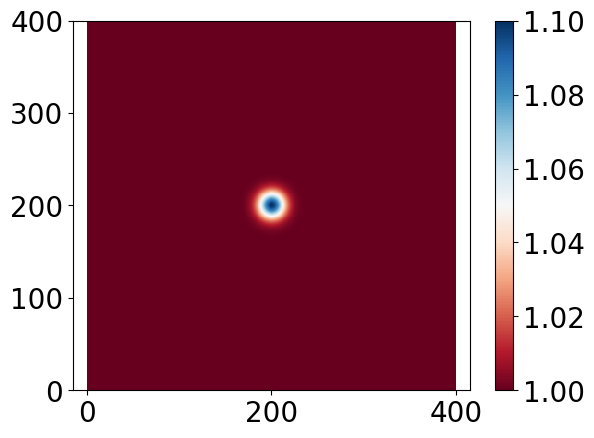

In [4]:
geq,rho,ux,uy = init()
plt.pcolormesh(rho,cmap='RdBu')
plt.colorbar()
plt.axis('equal')
print(rho[190,200])

<b>Collision:</b>  En développant l'étape de collision à  partir de la forme d'équilibre proposé, montrer qu'elle peut s'écrire simplement à  l'aide d'une combinaison linéaire des fonctions de distributions. On pourra écrire la forme simplifiée ci-dessous:
___
En remplacant $\tau_g$ par sa valeur numérique, on trouve l'expression simplifiée suivante:

$g_\alpha^{\text{coll}} = 2g_\alpha^{\text{eq}} - g_\alpha = \rho/2 + \rho/2\frac{u\cdot c_\alpha}{c_0^2} - g_\alpha$.

En détaillant pour chaque valeur de $\alpha$:

$g_1^{coll}= \rho/2 - g_{3} = 1/2(g_{1} + g_{2} - g_{3} + g_{4})   $

$g_2^{coll}= \rho/2 - g_{4} = 1/2(g_{1} + g_{2} + g_{3} - g_{4})    $

$g_3^{coll}= \rho/2 - g_{1} =  1/2(- g_{1} + g_{2} + g_{3} + g_{4})  $

$g_4^{coll} = \rho/2 - g_{2} =  1/2(g_{1} - g_{2} + g_{3} + g_{4})    $
___

In [6]:
def collide(gcoll,g,taug):
    # Etape de collision
    gcoll[0] = 1/2*(g[0,:,:] + g[1,:,:] - g[2,:,:] + g[3,:,:])
    gcoll[1] = 1/2*(g[0,:,:] + g[1,:,:] + g[2,:,:] - g[3,:,:])
    gcoll[2] = 1/2*(- g[0,:,:] + g[1,:,:] + g[2,:,:] + g[3,:,:])
    gcoll[3] = 1/2*(g[0,:,:] - g[1,:,:] + g[2,:,:] + g[3,:,:])
    return gcoll

<b>Propagation:</b> Pour cette étape on pourra utiliser du slicing plutôt qu'une boucle sur l'espace.

In [7]:
def propagate(g,gcoll):
    # Etape de propagation
    for i in range(1,nx-1):
        g[0,i,:] = gcoll[0,i - 1,:]
        g[2,i,:] = gcoll[2,i + 1,:]
    for j in range(1,ny - 1):
        g[1,:,j] = gcoll[1,:,j - 1]
        g[3,:,j] = gcoll[3,:,j + 1]
    return g

<b>Conditions aux limites:</b> Pour ce TP on choisira des conditions aux limites périodiques.    

In [8]:
def boundary(g,gcoll):
    # Conditions aux limites periodiques
    # Entree
    g[1,:,0] = gcoll[1,:,ny - 1]
    # Sortie
    g[3,:,ny - 1] = gcoll[3,:,0]
    # Bas
    g[0,0,:] = gcoll[0,nx - 1,:]
    # Haut
    g[2,nx - 1,:] = gcoll[2,0,:]
    return g

<b>Calcul des moments:</b> Calcul les variables macroscopiques $\rho$,$u_x$,$u_y$

In [9]:
def macro(g,rho,ux,uy):
    # calcul des variables macro
    rho = g[0,:,:] + g[1,:,:] + g[2,:,:] + g[3,:,:]
    ux = (g[0] - g[2])/rho
    uy = (g[1] - g[3])/rho
    return rho,ux,uy

<b>Ecriture des résultats:</b> Pour ce TP on enregistrera les profils de pression et de vitesse longitudinale sur la ligne $y=ny/2$.

In [10]:
def rec(prof,rho,ux):
    prof[t][:][0] = rho[:][floor(ny/2)]
    prof[t][:][1] = ux[:][floor(ny/2)]

<h2>Calcul</h2>

<b style="color:#0055FA">4. Initialiser les distributions à  leur valeur à  l'équilibre puis écrire la boucle temporelle permettant d'effectuer un calcul.</b>

In [18]:
geq,rho,ux,uy=init()
g,gcoll=geq.copy(),geq.copy()
prof=np.zeros((nt,nx,2))#profil de pression et vitesse en fonction du temps

t0=time.time()
for t in range(floor(nt/2)):

    gcoll = collide(gcoll,g,taug) # Collision
    g = propagate(g,gcoll) # Propagation
    g = boundary(g,gcoll) # Conditions aux limites
    rho,ux,uy = macro(g,rho,ux,uy) # Calcul des moments
t1 = time.time() - t0

<b style="color:#0055FA">5. Evaluer les performances de votre algorithme en calculant l'efficacité de votre calcul en MLUPS. (On utilisera pour cela la fonction time proposée)</b>

On utilise la formule : $MLUPS = \frac{10^{-6}N_{p}N_{t}}{T_{r}}$

On calcule $T_{r}$ grâce à la fonction time. On a calculé $N_{t}$, le nombre d'itération, dans la première partie, $N_{T} = 282$. Le nombre de point $N_{p}$ est aisé à calculer : $N_{p} = 400\times400 = 160 000$. Le calcul donne $T_{r} = 2.34698$.
\
Finalement, $MLUPS = 19.28$


<h2>Analyse des résultats</h2>
<h3>Solution numérique</h3>

<b style="color:#0055FA">6. Représenter la solution numérique obtenus. On pourra par exemple tracer $\rho$ et $u_x$ à  l'aide de la fonction <a href="https://matplotlib.org/stable/plot_types/arrays/pcolormesh.html">pcolormesh</a></b>

(array([  0., 100., 200., 300., 400.]),
 [Text(0, 0.0, '0'),
  Text(0, 100.0, '100'),
  Text(0, 200.0, '200'),
  Text(0, 300.0, '300'),
  Text(0, 400.0, '400')])

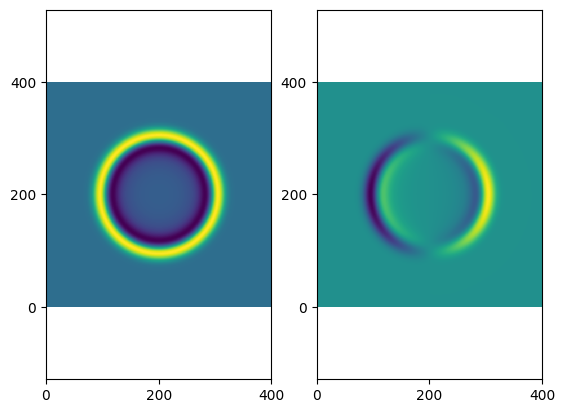

In [16]:
#Affichage du resultat

# make data with uneven sampling in x

# plot
fig= plt.figure()
fig.add_subplot(121)
plt.axis('equal')
plt.pcolormesh(rho)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

fig.add_subplot(122)
plt.axis('equal')
plt.pcolormesh(ux.T)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

<h3>Solution théorique</h3>


<b style="color:#0055FA">7. Calculer et tracer la solution théorique donnée plus haut à  l'aide des fonctions <i>integrande1</i> et <i>integrande2</i>. On pourra changer le nombre d'itérations si besoin.</b>

(0.0, 400.0, 0.0, 400.0)

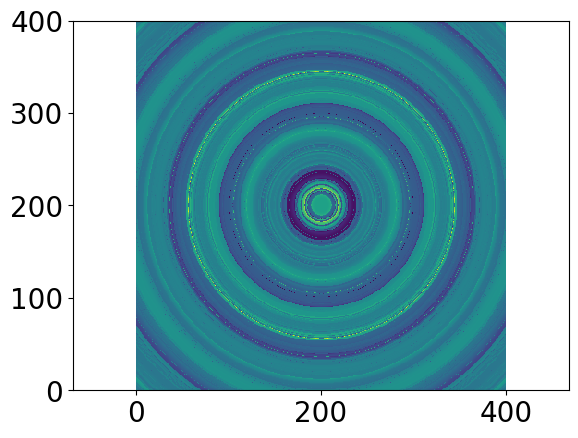

In [21]:
from scipy.integrate import quad
from scipy.special import j0,j1
#Le calcul prend énormèment de temps
t = nt/2
alpha = np.log(2)/b**2
eta = [[np.sqrt(((xj - 200)/400)**2 + ((yj - 200)/400)**2) for xj in range(nx)] for yj in range(ny)]

def integrande1(xi):
    global alpha,eta1,t
    y = eps/(2*alpha)*xi*np.exp(-xi**2/(4*alpha))*np.cos(t*xi)*j0(xi*eta1)
    return y

def integrande2(xi):
    global alpha,eta1,t
    y = eps*(xi-200)/(2*alpha*eta1)*xi*np.exp(-xi**2/(4*alpha))*np.sin(t*xi)*j1(xi*eta1)
    return y

# Utiliser la fonction quad(f,a,b) pour intégrer la fonction f entre 0 et une valeur arbitrairement grande
rho_th = np.zeros((nx,ny))
ux_th = np.zeros((nx,ny))
for i in range(nx):
    for j in range(ny):
        eta1 = eta[i][j]
        rho_th[i,j] = 1 + quad(integrande1,0, math.inf)[0]
        ux_th[i,j] = quad(integrande2,0,math.inf)[0]

plt.pcolormesh(rho_th)
plt.axis('equal')

(0.0, 400.0, 0.0, 400.0)

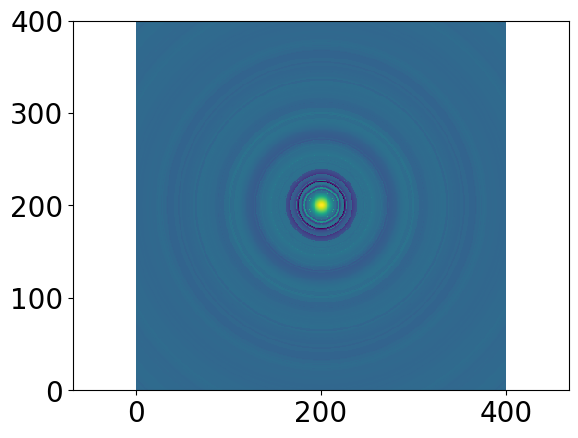

In [20]:
plt.pcolormesh(ux_th)
plt.axis('equal')

<b style="color:#0055FA"> 8. Comparer les profils de pression et de vitesse numérique et théorique. Commenter les résultats obtenus</b>


**Commentaires**
Le calcul théorique est très long (~35 min). On ne voit pas de grosses différences pour ce qui concerne $u_{x}$ et $u_{x}^{theo}$, mais il est clair que $\rho^{theo}$ semble assez éloigné de $\rho$.

La masse volumique et les vitesses simulés semblent très cohérentes. On observe une propagation de la pulse dans le milieu. La surface d'onde reste un cercle car la vitesse du son est constante dans tous le milieu.  
___

<h3>Convergence du maillage</h3>

<b style="color:#0055FA"> 9. En faisant varier la pas d'espace $\Delta x=\dfrac{L_x}{n_x} $, calculer pour chaque résolution la norme $L_2$ définie par:</b>

$$
L_2=\sqrt{\dfrac{1}{N}\sum_{i=1}^N (\rho_i^{num}-\rho_i^{th})^2}
$$


In [26]:
print(np.linalg.norm(rho - rho_th)/np.sqrt(np.prod(rho.shape)))

0.004520485851474901


<b style="color:#0055FA">10. En intégrant la fonction dans le calcul (Question 4.) tracer l'évolution de la norme en fonction de $\Delta x$. En déduire l'ordre du schéma.</b>

In [ ]:
...
...
...

**Comentaires**

___


___

# 4 - Conclusion

Présenter ici la synthèse de votre TP en décrivant les points importants et les principaux résultats.





In [ ]:
from IPython.core.display import HTML
style=open('notebooks.css', "r").read()
HTML(style)

<a id="top" style="float:right;" href="http://dynfluid.ensam.eu/"><img style="height:120px;" src="http://dynfluid.ensam.eu/uas/DYNFLUID/logoPrincipal/Logo-DynFluid-Web.png"/></a>
<a style="float:left;" href="http://www.cnam.fr//"><img style="height:120px;" src="https://upload.wikimedia.org/wikipedia/commons/4/45/Logo_ENSTA_Paris.jpg"></a>
<center><a href="#top">Retour en haut de la page</a></center>